# 0.Assignments

👾 這個陽春的聊天機器人需要被優化！<br>
若是一個對話串不間斷地持續進行，送進去的訊息量會很多，tokens數量也會跟著增加，會需要花比較多費用(💸💸💸)，也可能使模型的回應雜訊比較多而回應受到干擾，所以我們可以優化短期記憶。<br>
另外，我們希望優化使用者體驗，我們可以根據聊天的內容整理出使用者的屬性，並在每一次跟使用者聊天時，都能根據這個使用者的狀況給予客製化的回應，因此我們要加入長期記憶的功能！

<br>

### 1. 短期記憶優化

(1) 🔰 [基本版] 在短期記憶中，將chatbot node送入llm的訊息中加入trim的優化機制 (依據適當的tokens數量決定)


<br>

### 2. 加入長期記憶

加入長期記憶，讓聊天機器人能夠記住使用者的資訊（名字、偏好語言、興趣），在下一次對話也能針對同個使用者的資訊，給予個人化的回答。

(1) 🔰 [基本版]
- chatbot node: 在chatbot node中，將該使用者的資訊取出，讓入prompt中讓llm依據使用者的資訊給予個人化的回答

- write_memory node: 在每一次生成回答後，將使用者的資訊整理成一段對使用者的描述(使用llm，給予system prompt做指引，自行設計如何整理、需要整理哪些資訊)，將整理完的資訊整理到store (可跨threads存取的地方)。

- config: config從原本的短期記憶只有thread_id, 也要加入user_id

<img src="https://drive.google.com/uc?export=view&id=1H4Y0WplOi6R4Eo06Ac2JA_9TbZa2YaRD" width="100"/>


(2) 👨‍🎓 [進階版]
- chatbot node: 可以決定使用者的問題是否需要從長期記憶中取得資訊，以及需要取得什麼資訊
- write_memory node: 可以整理成特定格式 (例如：使用with_structured_output，相關概念可以延伸到R3 tool calling內容)。例如：
```
user_profile = {
  "first_name": "XXXX",
  "last_name": "OOO",
  "preferred_lang": ["en", "zh-tw"]
}
```
- 也可以自行將graph結構調整自己喜歡的(增刪不同node, conditional router, ...)
<br>
備註：基本版是需要大家完成的，進階版可以自行決定是否挑戰，Enjoy the ride! 😎

# 1.短期記憶

## (1) 基本版
🔰 [基本版] 在短期記憶中，將chatbot node送入llm的訊息中加入trim的優化機制 (依據適當的tokens數量決定)

note: 可以邊做邊看一下trim設定的效果以及內部運作的機制

In [1]:
%%capture --no-stderr
!pip install -U langgraph langchain_openai==0.3.15 langchain transformers bitsandbytes langchain-huggingface


In [ ]:
# from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig
# from langchain_huggingface import HuggingFacePipeline

# # 會需要一點時間
# # 使用 4-bit 量化模型
# model_id = "MediaTek-Research/Breeze-7B-Instruct-v1_0"

# quant_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_use_double_quant=True,
#     llm_int8_threshold=6.0,
# )

# # 載入 tokenizer 與 4-bit 模型
# tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
# model = AutoModelForCausalLM.from_pretrained(
#     model_id,
#     device_map="auto",
#     quantization_config=quant_config,
#     trust_remote_code=True
# )

In [ ]:
# generator = pipeline(
#     task="text-generation",
#     model=model,
#     tokenizer=tokenizer,
#     max_new_tokens=512,
#     do_sample=True,
#     temperature=0.4,
#     return_full_text=False # 僅返回生成的回應內容
# )

# # 包裝成 LangChain 的 llm 物件
# llm = HuggingFacePipeline(pipeline=generator)

In [2]:
import os
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')

In [17]:
from langchain_openai import ChatOpenAI
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace

# 課金openai
llm_api = ChatOpenAI(model="gpt-4o-mini")  # 你可以換成 "gpt-4" 或其他 OpenAI 模型名稱

# 呼叫huggingface上的API模型 (free)
llm_endpoint = HuggingFaceEndpoint(
    repo_id="Qwen/Qwen2.5-32B-Instruct",
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)

llm_huggingface = ChatHuggingFace(llm=llm_endpoint, verbose=False)

In [18]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import SystemMessage,HumanMessage, AIMessage,trim_messages
from langchain_core.messages.utils import count_tokens_approximately
from langgraph.checkpoint.memory import MemorySaver

class State(TypedDict):
  messages: Annotated[list, add_messages]

def chatbot(state: State):
  # 💻code below:
  # hint: you can use langchain_core trim_messages function to trim your trim_messages, and count_tokens_approximately to count tokens

  system_prompt = "你是個只能使用繁體中文回答的助理"
  system_message = [SystemMessage(content=system_prompt)]
  filter_message = trim_messages(
        messages=state["messages"],
        max_tokens=100,
        strategy="last",
        include_system=True,
        token_counter=count_tokens_approximately
    )
  response = llm_api.invoke(system_message+filter_message)
  return {"messages": [response]}


# 建立graph
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot) # 在graph裡面加入chatbot的node
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# 加入短期記憶
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)


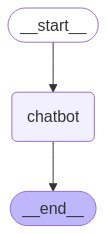

In [19]:
# 看一下graph
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
  print(e)
  pass

In [20]:
def stream_graph_updates(user_input: str, config: dict):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config):
      if "chatbot" in event:
        for value in event.values():
          print("Assistant:", value["messages"][-1].content)

In [21]:
# 設定對話config (第一次對話)
config = {"configurable": {"thread_id": "conversation_1"}} # thread_id: 對話id

In [23]:
# 開始對話 (可以輸入quit, exit, q，三選一停止對話)
while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
      print("Goodbye!")
      break
    stream_graph_updates(user_input, config)
  except Exception as e:
    print(e)
    break

User: 你好 我叫陳韻如
Assistant: 你好，陳韻如！很高興認識你。有什麼我可以幫助你的嗎？
User: 我愛吃蘋果
Assistant: 真好！蘋果不僅美味，還富含營養，對健康非常有益。你喜歡哪種類型的蘋果呢？例如，青蘋果還是紅蘋果？
User: 我們來聊別的吧
Assistant: 好的，請問你想聊什麼呢？電影、音樂、旅行，還是其他的話題？
User: 我喜歡聽音樂
Assistant: 太好了！聽音樂是一個放鬆心情的好方式。你喜歡哪種類型的音樂呢？或者有喜歡的歌手或樂團嗎？
User: 那你知道我喜歡吃什麼嗎
Assistant: 你之前提到你愛吃蘋果，還有其他喜歡的食物嗎？如果有的話，可以分享一下！
User: q
Goodbye!


---

# 2.長期記憶

## (1) 基本版
🔰 [基本版]
- chatbot node: 在chatbot node中，將該使用者的資訊取出，讓入prompt中讓llm依據使用者的資訊給予個人化的回答

- write_memory node: 在每一次生成回答後，將使用者的資訊整理成一段對使用者的描述(使用llm，給予system prompt做指引，自行設計如何整理、需要整理哪些資訊)，將整理完的資訊整理到store (可跨threads存取的地方)。

- config: config從原本的短期記憶只有thread_id, 也要加入user_id

<img src="https://drive.google.com/uc?export=view&id=1H4Y0WplOi6R4Eo06Ac2JA_9TbZa2YaRD" width="100"/>

In [24]:
%%capture --no-stderr
!pip install langchain_core

In [82]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver # within-thread memory
from langgraph.store.memory import InMemoryStore # cross-thread store

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
import json
in_memory_store = InMemoryStore()


class State(TypedDict):
  messages: Annotated[list, add_messages]

def chatbot(state: State):
  # 💻code here:
  # TODO:
  # 依據user_id取得長期記憶
  # 將長期記憶也放進system prompt中，讓llm可以個人化回覆
  user_id = "a"
  namespace_for_memory = (user_id, "memories")

  # 取得長期記憶
  memory_items = in_memory_store.get(namespace_for_memory)
  if memory_items:
      memory_prompt = "\n".join([f"{k}: {v}" for k, v in memory_items])
  else:
      memory_prompt = "(無個人化資料)"

  system_prompt = f"你是一個聊天助理，以下是使用者的個人資訊：\n{memory_prompt}\n請依據這些資訊個人化回覆。"
  system_message = SystemMessage(content=system_prompt)

  messages = [system_message] + state["messages"]

  response = llm_api.invoke(messages)
  return {"messages": [AIMessage(content=response.content)]}


def write_memory(state: State):

  # 💻code here:
  # TODO:
  # 將使用者的對話整理成要儲存成長期記憶的資訊，並存入長期記憶
  user_id ="a"
  namespace_for_memory = (user_id, "memories")
  existing_memory = dict(in_memory_store.get(namespace_for_memory))

  system_prompt = "請整理key value的格式，只保留有意義的名詞，無重要資訊可回傳空\n"
  system_message = [SystemMessage(content=system_prompt)]

  filter_message = trim_messages(
        messages=state["messages"],
        max_tokens=100,
        strategy="last",
        include_system=True,
        token_counter=count_tokens_approximately
    )
  response = llm_api.invoke(system_message+filter_message)
  try:
    kv_json = json.loads(response.content.split('\n',1)[1][::-1].split('\n',1)[1][::-1])
    for key,value in kv_json.items():
      in_memory_store.put(namespace_for_memory,key,value)
      if key not in existing_memory or existing_memory[key] != value:
        in_memory_store.put(namespace_for_memory, key, value)
  except:
    pass

# Define the graph
builder = StateGraph(State)
builder.add_node("chatbot", chatbot)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", "write_memory")
builder.add_edge("write_memory", END)


# Compile the graph with the checkpointer fir and store

# 💻Code Here
# 記得放入短期記憶，長期記憶的store
across_thread_memory = InMemoryStore()
within_thread_memory = MemorySaver()
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)


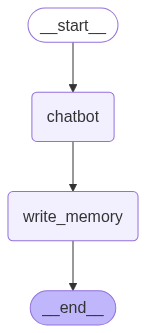

In [83]:
# View
from IPython.display import Image, display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
  print(e)
  pass

In [84]:
def stream_graph_updates(user_input: str, config: dict):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config):
        if "chatbot" in event:
          for value in event.values():
              print("Assistant:", value["messages"][-1].content)

In [85]:
# 使用者A的第一次對話
config = {"configurable": {"thread_id": "conversation_1", "user_id": "user_a"}}

In [86]:
# 開始對話 (可以輸入quit, exit, q，三選一停止對話)
while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
      print("Goodbye!")
      break
    stream_graph_updates(user_input, config)
  except Exception as e:
    print(e)
    break

User: 你好
BaseStore.get() missing 1 required positional argument: 'key'


In [ ]:
# 使用者A的第二次對話
config = {"configurable": {"thread_id": "conversation_2", "user_id": "user_a"}}

In [ ]:
# 開始對話 (可以輸入quit, exit, q，三選一停止對話)
while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
      print("Goodbye!")
      break
    stream_graph_updates(user_input, config)
  except Exception as e:
    print(e)
    break

## (2) 進階版

👨‍🎓 [進階版]
- chatbot node: 可以決定使用者的問題是否需要從長期記憶中取得資訊，以及需要取得什麼資訊
- write_memory node: 可以整理成特定格式 (例如：使用with_structured_output，相關概念可以延伸到R3 tool calling內容)。例如：
```
user_profile = {
  "first_name": "XXXX",
  "last_name": "OOO",
  "preferred_lang": ["en", "zh-tw"]
}
```
- 也可以自行將graph結構調整自己喜歡的(增刪不同node, conditional router, ...)

In [ ]:
# 💻code here, enjoy the ride 😎
